# Assignment 4
## Exercise 1
serial version of the wildfire simulation:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit

In [7]:
# Constants
GRID_SIZE = 800  # 800x800 forest grid
FIRE_SPREAD_PROB = 0.3  # Probability that fire spreads to a neighboring tree
BURN_TIME = 3  # Time before a tree turns into ash
DAYS = 60  # Maximum simulation time

# State definitions
EMPTY = 0  # No tree
TREE = 1  # Healthy tree
BURNING = 2  # Burning tree
ASH = 3  # Burned tree
NUM_WORKERS = 8  # Number of workers to use for parallel processing

In [8]:
def initialize_forest():
    """Creates a forest grid with all trees and ignites one random tree."""
    forest = np.ones((GRID_SIZE, GRID_SIZE), dtype=int)  # All trees
    burn_time = np.zeros(
        (GRID_SIZE, GRID_SIZE), dtype=int
    )  # Tracks how long a tree burns

    # Ignite a random tree
    x, y = random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1)
    forest[x, y] = BURNING
    burn_time[x, y] = 1  # Fire starts burning

    return forest, burn_time

In [9]:
def get_neighbors(x, y):
    """Returns the neighboring coordinates of a cell in the grid."""
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Up, Down, Left, Right
        nx, ny = x + dx, y + dy
        if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
            neighbors.append((nx, ny))
    return neighbors

In [10]:
def simulate_wildfire():
    """Simulates wildfire spread over time."""
    forest, burn_time = initialize_forest()
    
    fire_spread = []  # Track number of burning trees each day
    
    for day in range(DAYS):
        new_forest = forest.copy()
        
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if forest[x, y] == BURNING:
                    burn_time[x, y] += 1  # Increase burn time
                    
                    # If burn time exceeds threshold, turn to ash
                    if burn_time[x, y] >= BURN_TIME:
                        new_forest[x, y] = ASH
                    
                    # Spread fire to neighbors
                    for nx, ny in get_neighbors(x, y):
                        if forest[nx, ny] == TREE and random.random() < FIRE_SPREAD_PROB:
                            new_forest[nx, ny] = BURNING
                            burn_time[nx, ny] = 1
        
        forest = new_forest.copy()
        fire_spread.append(np.sum(forest == BURNING))
        
        if np.sum(forest == BURNING) == 0:  # Stop if no more fire
            break
        
        # # Plot grid every 5 days
        # if day % 5 == 0 or day == DAYS - 1:
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(forest, cmap='viridis', origin='upper')
        #     plt.title(f"Wildfire Spread - Day {day}")
        #     plt.colorbar(label="State: 0=Empty, 1=Tree, 2=Burning, 3=Ash")
        #     plt.show()
    
    return fire_spread

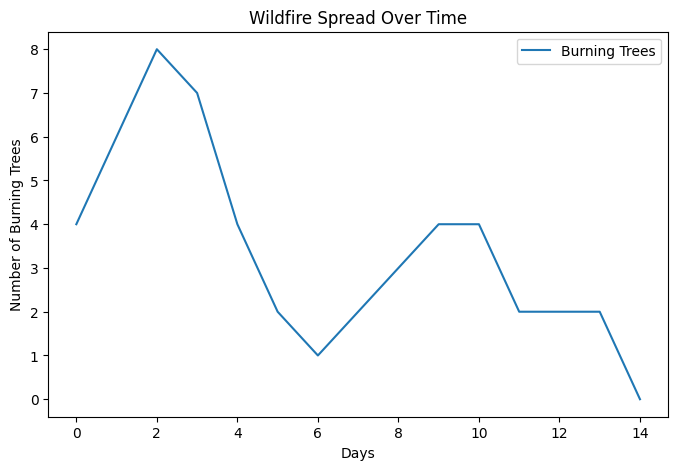

In [11]:
# Run simulation
start_time = timeit.default_timer()
fire_spread_over_time = simulate_wildfire()
for _ in range(NUM_WORKERS - 1):
    fire_spread_over_time = simulate_wildfire()
end_time = timeit.default_timer()
serial_time = end_time - start_time

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(
    range(len(fire_spread_over_time)), fire_spread_over_time, label="Burning Trees"
)
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.1 - Parallelization with Multiprocessing

In [12]:
import multiprocess as mp

In [13]:
def mp_simulate_wildfire(id):
    return simulate_wildfire()

In [14]:
# Run simulation
start_time = timeit.default_timer()
with mp.Pool(NUM_WORKERS) as pool:
    fire_spread_over_time = pool.map(mp_simulate_wildfire, range(NUM_WORKERS))
end_time = timeit.default_timer()
mp_parallel_time = end_time - start_time    

fire_spread_over_time_np = np.zeros((NUM_WORKERS, DAYS), dtype=int)

for i, spread in enumerate(fire_spread_over_time):
    fire_spread_over_time_np[i, : len(spread)] = (
        spread
    )
    
result = np.mean(fire_spread_over_time_np, axis=0)

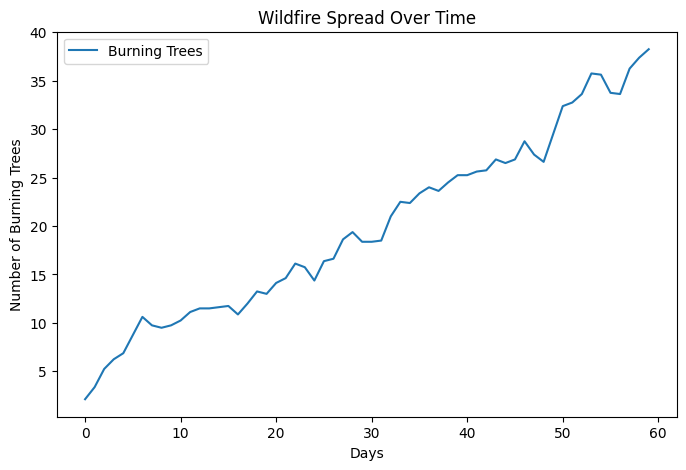

In [15]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(
    range(len(result)), result, label="Burning Trees"
)
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.2 - Parallelization with Dask

In [16]:
import dask
import dask.array as da
from dask.distributed import Client
client = Client()

In [17]:
@dask.delayed
def dask_simulate_wildfire():
    return simulate_wildfire()

In [18]:
# Run simulation
start_time = timeit.default_timer()
fire_spread_over_time = [dask_simulate_wildfire() for _ in range(NUM_WORKERS)]

computed_fire_spread = dask.compute(*fire_spread_over_time)
end_time = timeit.default_timer()
dask_parallel_time = end_time - start_time

fire_spread_over_time_np = da.from_array(np.zeros((NUM_WORKERS, DAYS), dtype=int), chunks=(NUM_WORKERS, DAYS))

for i, spread in enumerate(computed_fire_spread):
    fire_spread_over_time_np[i, : len(spread)] = (spread)

result = da.mean(fire_spread_over_time_np, axis=0).compute()

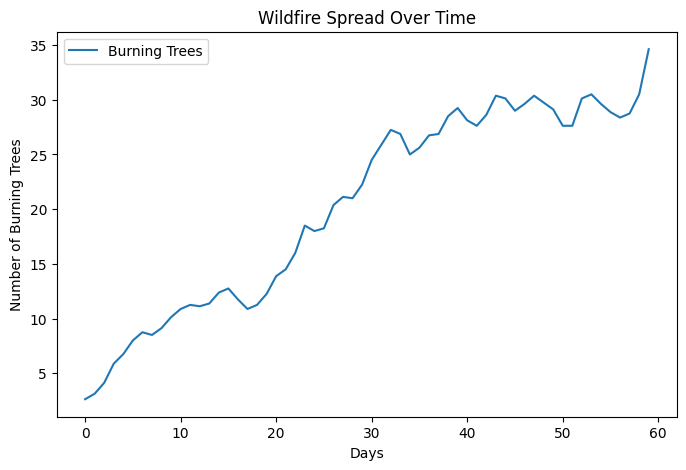

In [19]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(range(len(result)), result, label="Burning Trees")
plt.xlabel("Days")
plt.ylabel("Number of Burning Trees")
plt.title("Wildfire Spread Over Time")
plt.legend()
plt.show()

### Task 1.3 - Performance Comparison

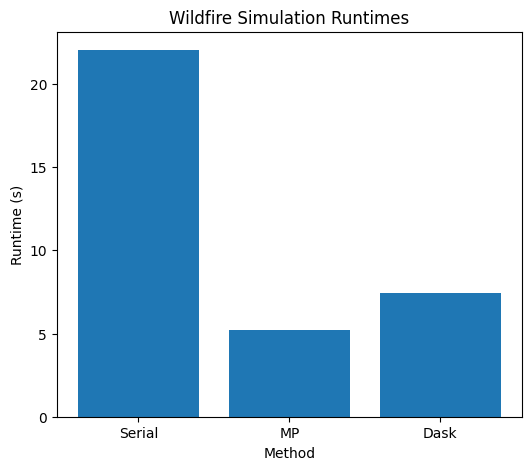

In [20]:
categories = ["Serial", "MP", "Dask"]
values = [serial_time, mp_parallel_time, dask_parallel_time]

# Create bar chart
plt.figure(figsize=(6, 5))
plt.bar(categories, values)

# Labels and title
plt.xlabel("Method")
plt.ylabel("Runtime (s)")
plt.title("Wildfire Simulation Runtimes")

# Show plot
plt.show()


### Task 1.4 - Visualization with Paraview and VTK

In [21]:
import pyvtk
np.float_ = np.float64

In [22]:
DAYS = 0

In [23]:
def save_forest_to_vtk(filename, forest):
    nx, ny = forest.shape

    state_flat = forest.T.flatten()

    vtk_data = pyvtk.VtkData(
        pyvtk.StructuredPoints([nx, ny, 1]),
        pyvtk.PointData(pyvtk.Scalars(state_flat, name="state")),
    )

    vtk_data.tofile(filename)

In [ ]:
def vtk_simulate_wildfire():
    """Simulates wildfire spread over time."""
    forest, burn_time = initialize_forest()

    fire_spread = []  # Track number of burning trees each day

    for day in range(DAYS):
        new_forest = forest.copy()

        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if forest[x, y] == BURNING:
                    burn_time[x, y] += 1  # Increase burn time

                    # If burn time exceeds threshold, turn to ash
                    if burn_time[x, y] >= BURN_TIME:
                        new_forest[x, y] = ASH

                    # Spread fire to neighbors
                    for nx, ny in get_neighbors(x, y):
                        if (
                            forest[nx, ny] == TREE
                            and random.random() < FIRE_SPREAD_PROB
                        ):
                            new_forest[nx, ny] = BURNING
                            burn_time[nx, ny] = 1

        forest = new_forest.copy()
        fire_spread.append(np.sum(forest == BURNING))

        # Write VTK file for visualization in ParaView
        vtk_filename = f"wildfire_day{day:03d}"
        save_forest_to_vtk(vtk_filename, forest)

        if np.sum(forest == BURNING) == 0:  # Stop if no more fire
            break

        # # Plot grid every 5 days
        # if day % 5 == 0 or day == DAYS - 1:
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(forest, cmap='viridis', origin='upper')
        #     plt.title(f"Wildfire Spread - Day {day}")
        #     plt.colorbar(label="State: 0=Empty, 1=Tree, 2=Burning, 3=Ash")
        #     plt.show()

    return fire_spread


In [25]:
# Run simulation and generate VTK files
_ = vtk_simulate_wildfire()

## Bonus
Original code:

In [26]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Grid size
grid_size = 200
TIME_STEPS = 100

In [29]:
# Initialize temperature field (random values between 5C and 30C)
temperature = np.random.uniform(5, 30, size=(grid_size, grid_size))

# Initialize velocity fields (u: x-direction, v: y-direction)
u_velocity = np.random.uniform(-1, 1, size=(grid_size, grid_size))
v_velocity = np.random.uniform(-1, 1, size=(grid_size, grid_size))

# Initialize wind influence (adds turbulence)
wind = np.random.uniform(-0.5, 0.5, size=(grid_size, grid_size))

def laplacian(field):
    """Computes the discrete Laplacian of a 2D field using finite differences."""
    lap = (
        np.roll(field, shift=1, axis=0) +
        np.roll(field, shift=-1, axis=0) +
        np.roll(field, shift=1, axis=1) +
        np.roll(field, shift=-1, axis=1) -
        4 * field
    )
    return lap

def update_ocean(u, v, temperature, wind, alpha=0.1, beta=0.02):
    """Updates ocean velocity and temperature fields using a simplified flow model."""    
    u_new = u + alpha * laplacian(u) + beta * wind
    v_new = v + alpha * laplacian(v) + beta * wind
    temperature_new = temperature + 0.01 * laplacian(temperature)  # Small diffusion
    return u_new, v_new, temperature_new

# Run the simulation
for t in range(TIME_STEPS):
    u_velocity, v_velocity, temperature = update_ocean(u_velocity, v_velocity, temperature, wind)
    if t % 10 == 0 or t == TIME_STEPS - 1:
        print(f"Time Step {t}: Ocean currents updated.")

Time Step 0: Ocean currents updated.
Time Step 10: Ocean currents updated.
Time Step 20: Ocean currents updated.
Time Step 30: Ocean currents updated.
Time Step 40: Ocean currents updated.
Time Step 50: Ocean currents updated.
Time Step 60: Ocean currents updated.
Time Step 70: Ocean currents updated.
Time Step 80: Ocean currents updated.
Time Step 90: Ocean currents updated.
Time Step 99: Ocean currents updated.


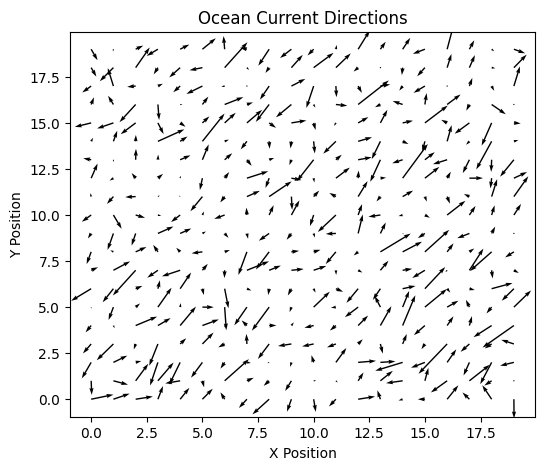

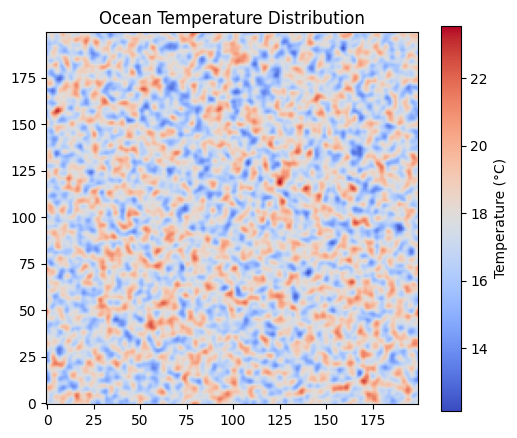

Simulation complete.


In [30]:
# Plot the velocity field
plt.figure(figsize=(6, 5))
plt.quiver(u_velocity[::10, ::10], v_velocity[::10, ::10])
plt.title("Ocean Current Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

# Plot temperature distribution
plt.figure(figsize=(6, 5))
plt.imshow(temperature, cmap="coolwarm", origin="lower")
plt.colorbar(label="Temperature (°C)")
plt.title("Ocean Temperature Distribution")
plt.show()

print("Simulation complete.")

### Task B.1 Dask

In [ ]:
import dask
import dask.array as da
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np

client = Client()

2025-02-24 17:32:03,952 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:59267' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 2.9, 2.9), ('concatenate-2e93fc6cac78a3a4a77a2c2344a8a5f0', 2, 3), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 2, 2), ('concatenate-2e93fc6cac78a3a4a77a2c2344a8a5f0', 3, 2), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 1.9, 1.9), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 1.9, 2), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 2.9, 2), ('uniform-38feed368618c633d3c601818f724d44', 1, 1), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 2, 2.9), ('uniform-d4d75b66f54e4a8eb3a9936ef24d65d9', 0, 1), ('getitem-ac6124eff34b48b0fcdf62ce2b3ee53f', 2, 1.9)} (stimulus_id='handle-worker-cleanup-1740414723.952524')
2025-02-24 17:32:03,954 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:59294' caused the cluster to lose already computed task(s), which

In [3]:
# Grid size
GRID_SIZE = 200
TIME_STEPS = GRID_SIZE // 2

DEPTH=1

BATCH_SIZE = 50

CHUNK_SIZE = GRID_SIZE // 2
CHUNK_WIDTH = CHUNK_SIZE
CHUNK_HEIGHT = CHUNK_SIZE
BOUNDARY_TYPE = 'reflect'

In [4]:
# Initialize temperature field (random values between 5C and 30C)
temperature = da.random.uniform(5, 30, size=(GRID_SIZE, GRID_SIZE), chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))

# Initialize velocity fields (u: x-direction, v: y-direction)
u_velocity = da.random.uniform(-1, 1, size=(GRID_SIZE, GRID_SIZE), chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))
v_velocity = da.random.uniform(-1, 1, size=(GRID_SIZE, GRID_SIZE), chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))

# Initialize wind influence (adds turbulence)
wind = da.random.uniform(-0.5, 0.5, size=(GRID_SIZE, GRID_SIZE), chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))


def laplacian(field):
    """Computes the discrete Laplacian of a 2D field using finite differences."""
    return (
        np.roll(field, shift=1, axis=0)
        + np.roll(field, shift=-1, axis=0)
        + np.roll(field, shift=1, axis=1)
        + np.roll(field, shift=-1, axis=1)
        - 4 * field
    )


def update_ocean(u, v, temperature, wind, alpha=0.1, beta=0.02):
    """Updates ocean velocity and temperature fields using a simplified flow model."""
    # Note: Persisting arrays outside the update loop improves performance.
    u_new = da.map_overlap(
        lambda x, w: x + alpha * laplacian(x) + beta * w,
        u,
        wind,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=u.dtype,
    )
    v_new = da.map_overlap(
        lambda x, w: x + alpha * laplacian(x) + beta * w,
        v,
        wind,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=v.dtype,
    )
    temperature_new = da.map_overlap(
        lambda x: x + 0.01 * laplacian(x),
        temperature,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=temperature.dtype,
    )
    return u_new, v_new, temperature_new


# Persist the arrays once to keep them in memory during updates
u_velocity, v_velocity, temperature, wind = dask.persist(
    u_velocity, v_velocity, temperature, wind
)


# Run the simulation loop
for t in range(TIME_STEPS):
    u_velocity, v_velocity, temperature = update_ocean(
        u_velocity, v_velocity, temperature, wind
    )
    if t % 10 == 0 or t == TIME_STEPS - 1:
        print(f"Time step {t}: update complete.")

# Trigger computation of the final results
final_u, final_v, final_temperature = dask.compute(u_velocity, v_velocity, temperature)


Time step 0: update complete.
Time step 10: update complete.
Time step 20: update complete.
Time step 30: update complete.
Time step 40: update complete.
Time step 50: update complete.
Time step 60: update complete.
Time step 70: update complete.
Time step 80: update complete.
Time step 90: update complete.
Time step 99: update complete.


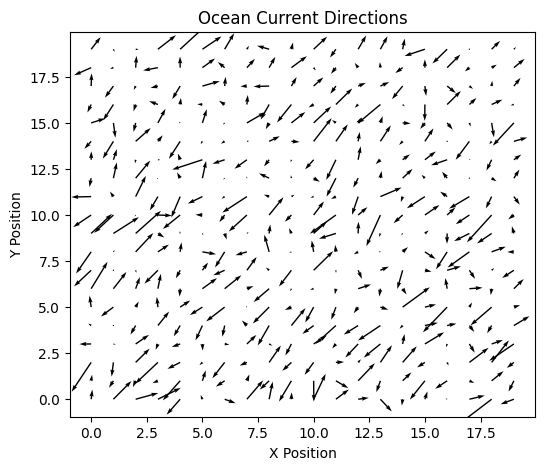

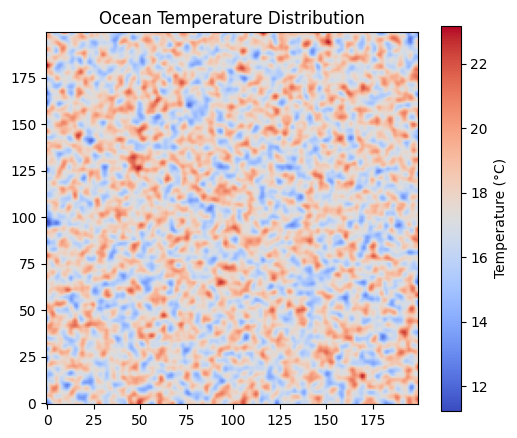

In [5]:
# # Plot the velocity field
plt.figure(figsize=(6, 5))
plt.quiver(u_velocity[::10, ::10], v_velocity[::10, ::10])
plt.title("Ocean Current Directions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.show()

# # Plot temperature distribution
plt.figure(figsize=(6, 5))
plt.imshow(temperature, cmap="coolwarm", origin="lower")
plt.colorbar(label="Temperature (°C)")
plt.title("Ocean Temperature Distribution")
plt.show()

# print("Simulation complete.")

## Task B.2
### Task B2.1
Pretty equal distribution of work between the workers.
### Task B2.2
`200x200` fastest time with least amount of memory
`100x100` slower time with more amount of memory
`50x50` slowest time with most amount of memory

This is probably due to the fact that the workers are spending more time communicating with each other than actually doing the work and since we can fit the whole dataset in memory, it is better to use the full chunk size.

### Task B2.3
While slower and more memory intense the smaller chunk sizes offered better worker balance however this did not matter since the workers never ran out of memory. The smaller the chunk the bigger the task queueing which meant a greater initial delay due to task scheduling as well as huge performance costs due to constant calls to transfer-overlap-getitem.
### Task B2.4

In [6]:
import pyvista as pv

In [9]:
import numpy as np
import dask.array as da
import dask
import meshio

# Simulation parameters (set these as needed)
GRID_SIZE = 100
CHUNK_WIDTH = 50
CHUNK_HEIGHT = 50
TIME_STEPS = 20
DEPTH = 1
BOUNDARY_TYPE = "periodic"  # e.g., "periodic", "reflect", "nearest"

# Create 2D coordinate mesh for output: a simple 0..(GRID_SIZE-1) range
x_coords = np.linspace(0, GRID_SIZE - 1, GRID_SIZE)
y_coords = np.linspace(0, GRID_SIZE - 1, GRID_SIZE)
X, Y = np.meshgrid(x_coords, y_coords)

# -----------------------------------------------------------------------------
# 1) Initialize random fields
# -----------------------------------------------------------------------------
# Temperature between 5 and 30
temperature = da.random.uniform(5, 30,
                                size=(GRID_SIZE, GRID_SIZE),
                                chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))

# Velocity fields: random in both x and y directions
u_velocity = da.random.uniform(-1, 1,
                               size=(GRID_SIZE, GRID_SIZE),
                               chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))
v_velocity = da.random.uniform(-1, 1,
                               size=(GRID_SIZE, GRID_SIZE),
                               chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))

# Two separate "wind" fields, so that we can add random forcing in x, y
wind_x = da.random.uniform(-0.5, 0.5,
                           size=(GRID_SIZE, GRID_SIZE),
                           chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))
wind_y = da.random.uniform(-0.5, 0.5,
                           size=(GRID_SIZE, GRID_SIZE),
                           chunks=(CHUNK_WIDTH, CHUNK_HEIGHT))

# -----------------------------------------------------------------------------
# 2) Define laplacian and update steps
# -----------------------------------------------------------------------------
def laplacian(field):
    """Computes the discrete Laplacian of a 2D field using finite differences."""
    return (
        np.roll(field, shift=1, axis=0)
        + np.roll(field, shift=-1, axis=0)
        + np.roll(field, shift=1, axis=1)
        + np.roll(field, shift=-1, axis=1)
        - 4 * field
    )

def update_ocean(u, v, temp, wx, wy, alpha=0.1, beta=0.02):
    """
    Updates ocean velocity (u,v) and temperature fields using a simplified flow model.
    alpha, beta: coefficients for diffusion & random wind forcing
    """
    # Update u-velocity
    u_new = da.map_overlap(
        lambda uu, wxx: uu + alpha * laplacian(uu) + beta * wxx,
        u, wx,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=u.dtype,
    )
    # Update v-velocity
    v_new = da.map_overlap(
        lambda vv, wyy: vv + alpha * laplacian(vv) + beta * wyy,
        v, wy,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=v.dtype,
    )
    # Update temperature (simple diffusion)
    temp_new = da.map_overlap(
        lambda tt: tt + 0.01 * laplacian(tt),
        temp,
        depth=DEPTH,
        boundary=BOUNDARY_TYPE,
        align_arrays=True,
        dtype=temp.dtype,
    )
    return u_new, v_new, temp_new

# -----------------------------------------------------------------------------
# 3) Persist arrays to keep them in memory (optional performance optimization)
# -----------------------------------------------------------------------------
u_velocity, v_velocity, temperature, wind_x, wind_y = dask.persist(
    u_velocity, v_velocity, temperature, wind_x, wind_y
)

# -----------------------------------------------------------------------------
# 4) Delayed function to write VTK per time step
# -----------------------------------------------------------------------------
@dask.delayed
def write_vtk(time, u_np, v_np, temp_np, filename):
    """
    Writes a VTK file for the given time step using meshio.
    - u_np, v_np, temp_np are already computed numpy arrays
    """
    # Flatten the 2D grid to (N, 3) points. z=0 for all since this is 2D.
    points = np.column_stack([
        X.ravel(order='C'),
        Y.ravel(order='C'),
        np.zeros(X.size, dtype=np.float32)
    ])

    # Flatten the fields in the same order
    u_flat = u_np.ravel(order='C')
    v_flat = v_np.ravel(order='C')
    temp_flat = temp_np.ravel(order='C')

    # Combine velocity into a 3D vector with zero z-component
    velocity_vec = np.column_stack([u_flat, v_flat, np.zeros_like(u_flat)])

    # For an unstructured mesh, define "vertex" cells
    cells = [("vertex", np.arange(points.shape[0]).reshape(-1, 1))]

    # Attach point data
    point_data = {
        "velocity": velocity_vec,
        "temperature": temp_flat
    }

    # Create mesh and write
    mesh = meshio.Mesh(points, cells, point_data=point_data)
    meshio.write(filename, mesh, file_format="vtk", binary=False)

    print(f"[Time {time}] Wrote file: {filename}")
    return filename

# -----------------------------------------------------------------------------
# 5) Main simulation loop
# -----------------------------------------------------------------------------
write_tasks = []

for t in range(TIME_STEPS):
    # Update velocity & temperature
    u_velocity, v_velocity, temperature = update_ocean(
        u_velocity, v_velocity, temperature, wind_x, wind_y
    )

    # Optionally print progress
    if t % 5 == 0 or t == TIME_STEPS - 1:
        print(f"Time step {t}: update complete.")

    # Compute the fields to numpy to pass to writer
    u_np, v_np, temp_np = dask.compute(u_velocity, v_velocity, temperature)

    # Create a time-tagged filename
    filename = f"flow_t{t:03d}.vtk"

    # Schedule the writing as a delayed task (or do it immediately)
    wt = write_vtk(t, u_np, v_np, temp_np, filename)
    write_tasks.append(wt)

# Either compute all VTK writes now or do it in a loop
dask.compute(*write_tasks)


Time step 0: update complete.


KeyboardInterrupt: 